# DBSCAN

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
import seaborn as sns
import os

Algorithm:
1. Copy `X` to the new vector `X_clean`
2. Generate vector `X_diff` of the form
$$\mathbf x^* = (x^*_1, x^*_2, \dots, x^*_T) \\ x^*_t = \frac{x_t - x_{t-1}}{|\mathbf x|}$$
where $\mathbf x = (x_1, x_2, \dots, x_T)$
3. Apply DBSCAN to `X_diff` adjusting $\varepsilon$ and find the best $\varepsilon$ that separate the largest cluster (signal) and others (noise)
4. Delete observations from `X_clean` according to the noise in `X_diff`
5. Linearly interpolate deleted values
6. Repeat steps 2-5 once again

## Data preparation

Calculate differences

In [23]:
sample = pd.read_csv('../data/sample9.csv')

sample_diff = sample.copy()

X = sample.X / np.linalg.norm(sample.X)
sample_diff.X = np.concatenate(([0], (X[1:].values) - X[:-1].values))

Truth = sample.Truth / np.linalg.norm(sample.Truth)
sample_diff.Truth = np.concatenate(([0], (Truth[1:].values) - Truth[:-1].values))

Plot the original signal and differences

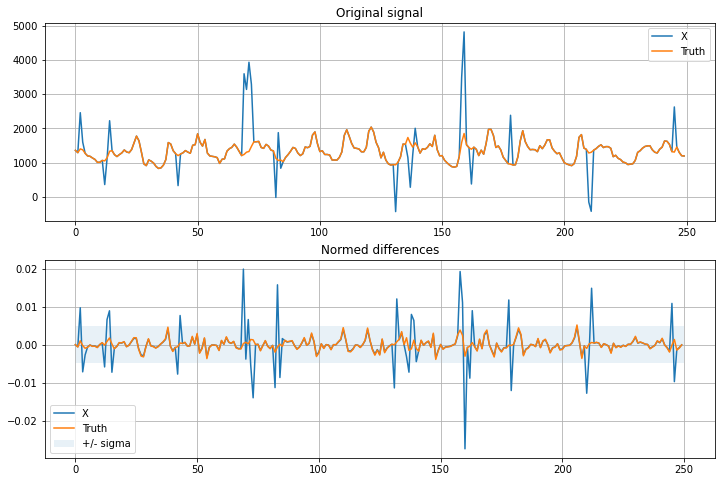

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
sample[:250].plot(ax=plt.gca())
plt.title('Original signal')
plt.grid()

plt.subplot(212)
sample_diff[:250].plot(ax=plt.gca())
plt.fill_between(
    [0, 250], 
    sample_diff.X.mean() + sample_diff.X.std(), 
    sample_diff.X.mean() - sample_diff.X.std(), 
    alpha=0.1,
    label='+/- sigma'
)

plt.title('Normed differences')
plt.legend()
plt.grid()

plt.show()

## DBSCAN

In [25]:
def eps_fit(X_diff, n):
    cluster_size = []
    for eps in eps_space:
        dbscan = DBSCAN(eps=eps).fit(X_diff[:n])
        largest_size = 0
        for label in set(dbscan.labels_):
            len_set = (dbscan.labels_ == label).sum()
            if largest_size < len_set:
                largest_size = len_set
        cluster_size.append(largest_size / n * 100)
    cluster_size = np.array(cluster_size)

    best_eps = eps_space[np.argmax(cluster_size[1:] - cluster_size[:-1]) + 1]
    
    plt.figure(figsize=(12, 4))
    plt.plot(eps_space, cluster_size)
    plt.plot([best_eps, best_eps], [cluster_size.min(), cluster_size.max()])
    plt.xlabel('epsilon')
    plt.ylabel('size of largest cluster, %')
    plt.grid()
    plt.show()
    
    return best_eps    

def plot_dbscan(X_diff, eps):
    dbscan = DBSCAN(eps=eps).fit(X_diff)
    sns.scatterplot(
        X_diff.ravel(), 
        np.random.uniform(size=len(X_diff)), 
        hue=dbscan.labels_,
        linewidth=0.5,
        palette='Set1',
        legend = False
    )
    plt.title('epsilon {}'.format(round(dbscan.eps, 5)))

def plot_eps(X_diff, best_eps):
    plt.figure(figsize=(12, 14))

    plt.subplot(311)
    plot_dbscan(X_diff, eps_space.min())

    plt.subplot(312)
    plot_dbscan(X_diff, best_eps)

    plt.subplot(313)
    plot_dbscan(X_diff, eps_space.max())
    
    plt.show()

def update_result(X_diff, best_eps):
    dbscan = DBSCAN(eps=best_eps).fit(X_diff)
    largest_size = 0
    largest_cluster = None
    for label in set(dbscan.labels_):
        len_set = (dbscan.labels_ == label).sum()
        if largest_size < len_set:
            largest_size = len_set
            largest_cluster = label
    
    sample.X_clean[dbscan.labels_ != largest_cluster] = None
    sample.X_clean = sample.X_clean.interpolate()
    
    plt.figure(figsize=(12, 4))
    for col in ['Truth', 'X', 'X_clean']:
        plt.plot(sample[col][:250], label=col)
    plt.legend()
    plt.show()

Iteration 1


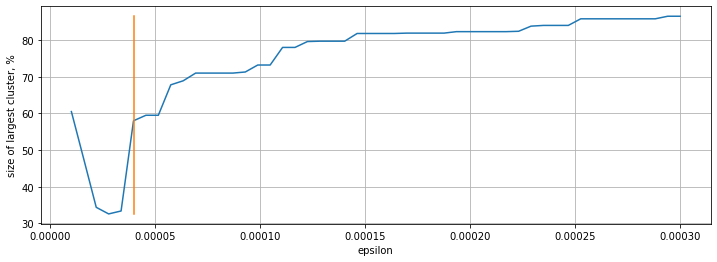

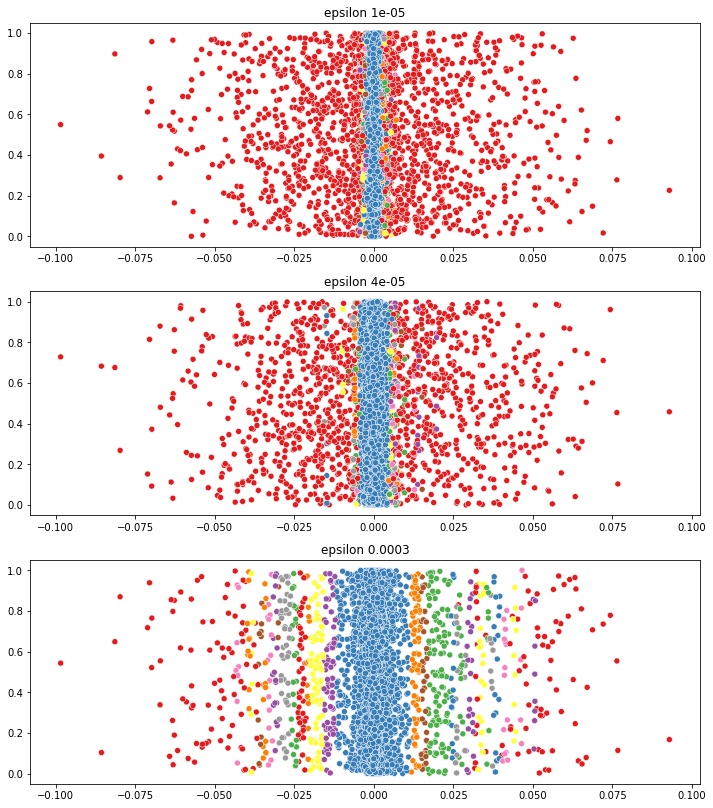

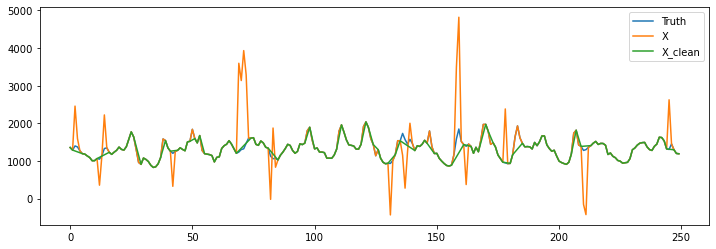

RMSE 189.38916067989615
Iteration 2


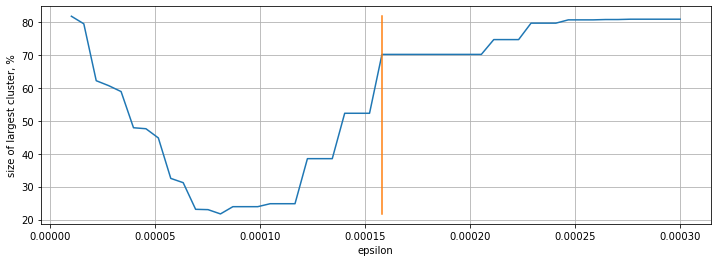

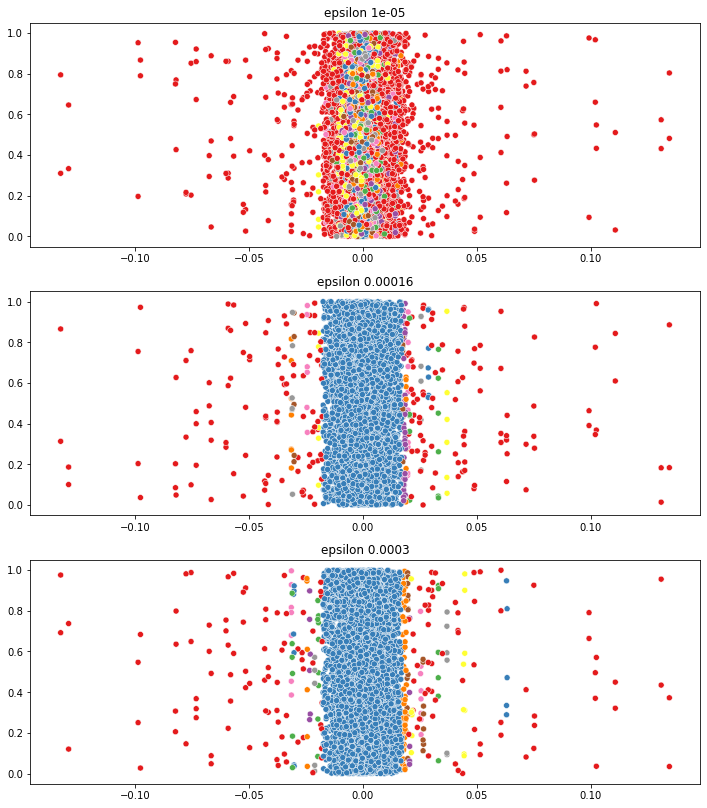

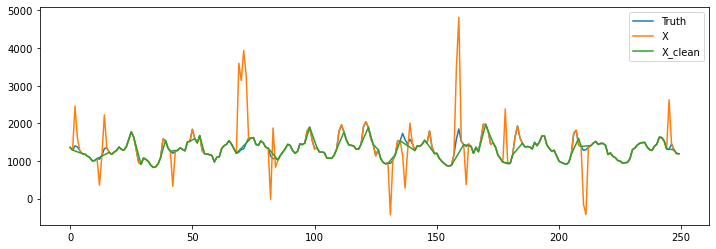

RMSE 102.11892118941009
Iteration 3


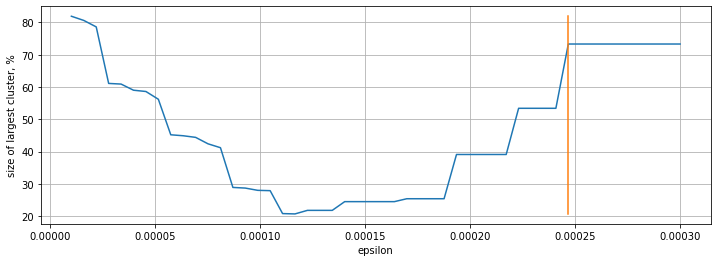

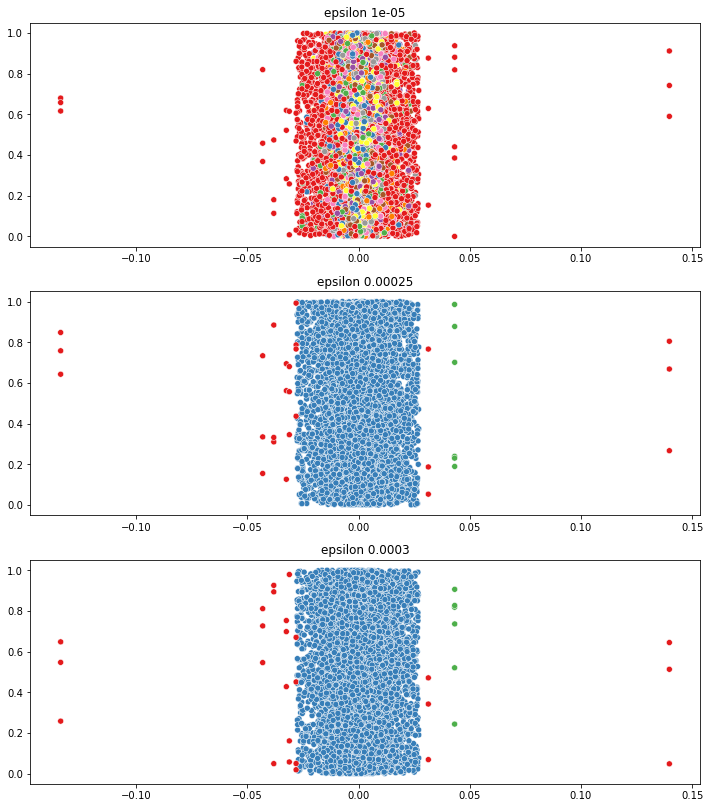

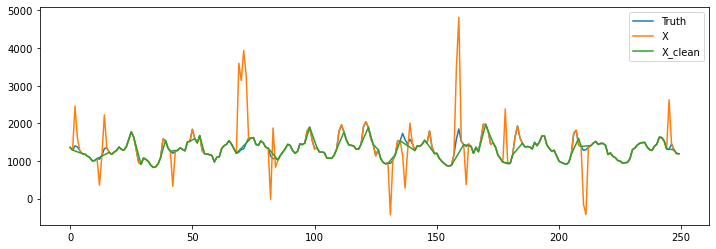

RMSE 94.11039930666877


In [26]:
sample['X_clean'] = sample.X
eps_space = np.linspace(0.00001, 0.0003, 50)
for i in range(3):
    print('Iteration {}'.format(i + 1))
    
    X_normed = sample.X_clean
    X_diff = np.concatenate(([0], (X_normed[1:].values) - X_normed[:-1].values))
    X_diff = X_diff /  np.linalg.norm(X_diff)
    X_diff = np.reshape(X_diff.tolist(), (X_diff.shape[0], 1))
    
    best_eps = eps_fit(X_diff, 1000)
    plot_eps(X_diff, best_eps)
    update_result(X_diff, best_eps)
    print(
        'RMSE',
        mean_squared_error(sample.Truth, sample.X_clean, squared=False)
    )

## Run tests

In [6]:
def dbscan_diff(X):
    
    n = 1000 # number of observations for fitting
    X_clean = X.copy()
    
    for i in range(2):
    
        # calculate diff
        X_normed = X_clean / np.linalg.norm(X_clean)
        X_diff = np.concatenate(([0], (X_normed[1:]) - X_normed[:-1]))
        X_diff = np.reshape(X_diff, (X_diff.shape[0], 1))

        # fit eps
        eps_space = np.linspace(0.00001, 0.00025, 100)
        cluster_size = []
        for eps in eps_space:
            dbscan = DBSCAN(eps=eps).fit(X_diff[:n])
            largest_size = 0
            for label in set(dbscan.labels_):
                len_set = (dbscan.labels_ == label).sum()
                if largest_size < len_set:
                    largest_size = len_set
            cluster_size.append(largest_size / n * 100)
        cluster_size = np.array(cluster_size)
        best_eps = eps_space[np.argmax(cluster_size[1:] - cluster_size[:-1]) + 1]

        # clustering
        dbscan = DBSCAN(eps=best_eps).fit(X_diff)

        # updating
        largest_size = 0
        largest_cluster = None
        for label in set(dbscan.labels_):
            len_set = (dbscan.labels_ == label).sum()
            if largest_size < len_set:
                largest_size = len_set
                largest_cluster = label

        X_clean[dbscan.labels_ != largest_cluster] = None
        X_clean = pd.Series(X_clean).interpolate().values
    
    return X_clean

In [7]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = dbscan_diff(X)
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [8]:
report_dbscan = run_tests('../data/')
report_dbscan

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.1255687513679229
File:  ../data/sample2.csv
RMSE:  0.06705742085007954
File:  ../data/sample3.csv
RMSE:  0.08977459336927648
File:  ../data/sample4.csv
RMSE:  0.1420217099039798
File:  ../data/sample5.csv
RMSE:  0.3535717079897222
File:  ../data/sample6.csv
RMSE:  1.0207152506045793
File:  ../data/sample7.csv
RMSE:  4.49079163311899
File:  ../data/sample8.csv
RMSE:  0.3684607553173544
File:  ../data/sample9.csv
RMSE:  102.11892118941009


Sample        RMSE
0  ../data/sample1.csv    0.125569
1  ../data/sample2.csv    0.067057
2  ../data/sample3.csv    0.089775
3  ../data/sample4.csv    0.142022
4  ../data/sample5.csv    0.353572
5  ../data/sample6.csv    1.020715
6  ../data/sample7.csv    4.490792
7  ../data/sample8.csv    0.368461
8  ../data/sample9.csv  102.118921

In [10]:
board = pd.DataFrame(columns=['Data preparation', 'Model']+['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['Neighbors\' difference', 'DBSCAN'] + list(report_dbscan['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3   sample4  \
Data preparation      Model                                            
Neighbors' difference DBSCAN  0.125569  0.067057  0.089775  0.142022   

                               sample5   sample6   sample7   sample8  \
Data preparation      Model                                            
Neighbors' difference DBSCAN  0.353572  1.020715  4.490792  0.368461   

                                 sample9  
Data preparation      Model               
Neighbors' difference DBSCAN  102.118921

In [11]:
board.iloc[[0], :].to_csv('../results/neigh_diff_dbscan.csv')